# DDPG Main

## Data Preprocessing

In [379]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import random
from collections import deque
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import gymnasium
from gymnasium import spaces


# Load data
#C:\Users\rohit\OneDrive\Documents\Asset-Pricing-with-Reinforcement-Learning\XOM_30_minute_6_month_data.csv
df = pd.read_csv('XOM_30_minute_6_month_data.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)

# Calculate the 10-period moving average
# df['10_MA'] = df['Last Price'].rolling(window=10).mean()
# df.to_csv('XOM_30_minute_6_month_data.csv', index=False)

# Used for unnormalization
last_price_scaler = MinMaxScaler()
last_price_scaler.fit(df[['Last Price']])
# Normalise data
scaler = MinMaxScaler()
df[['Last Price', 'Volume', 'SMAVG (15)', '10_MA']] = scaler.fit_transform(df[['Last Price', 'Volume', 'SMAVG (15)', '10_MA']])


# Split into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

print(train_df[10:])

                    Date  Last Price    Volume  SMAVG (15)     10_MA
10   2023-03-08 18:00:00    0.499995  0.043372    0.074594  0.544225
11   2023-03-08 18:30:00    0.521974  0.046837    0.076402  0.535888
12   2023-03-08 19:00:00    0.527885  0.038593    0.075786  0.527086
13   2023-03-08 19:30:00    0.505948  0.067524    0.078888  0.512765
14   2023-03-08 20:00:00    0.492211  0.085734    0.084456  0.499824
...                  ...         ...       ...         ...       ...
1861 2023-10-02 15:00:00    0.755034  0.144825    0.184963  0.865106
1862 2023-10-02 15:30:00    0.762818  0.113712    0.166506  0.851449
1863 2023-10-02 16:00:00    0.764192  0.092697    0.157100  0.838893
1864 2023-10-02 16:30:00    0.761445  0.078738    0.145187  0.827026
1865 2023-10-02 17:00:00    0.771747  0.055809    0.135850  0.818920

[1856 rows x 5 columns]


## Environment

In [380]:
class DDPGTradingEnv(gymnasium.Env):

  def __init__(self, df):
    super().__init__()
    
    self.df = df
    self.current_step = 0
    self.total_steps = 650 #len(df) - 1

    # Negatives mean quantity to sell, 0 is hold, positives mean buy
    self.action_space = spaces.Box(low=-1, high=1, shape=(1, ), dtype=np.float32)
    # Observation space: normalized last price, normalized shares held, normalized cash balance
    self.observation_space = spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)

    self.reset()

  def reset(self):
    self.current_step = 0
    self.total_profit = 0
    self.cash_balance = 10000
    self.max_share_order = 90
    self.shares_held = 0
    self.portfolio_value = self.cash_balance
    self.previous_portfolio_value = self.portfolio_value
    # For plotting
    self.portfolio_history = [np.array([self.portfolio_value], dtype=np.float32)]

    return self.get_observation()

  def get_observation(self):
    current_price = self.df.loc[self.current_step, 'Last Price']
    volume = self.df['Volume'].iloc[self.current_step]
    MA_10 = self.df['10_MA'].iloc[self.current_step]
    return np.array([float(current_price), float(self.shares_held), float(self.cash_balance), float(volume), float(MA_10)])

  def take_action(self, num_shares):
    normalised_current_price = self.df.loc[self.current_step, 'Last Price']
    # Inverse transform to get the un-normalized current price
    current_price = last_price_scaler.inverse_transform([[normalised_current_price]])
    # Checks if we have enough cash to buy
    print("num_shares: ", num_shares)
    print("current_price: ", current_price)
    if num_shares > 0 and self.cash_balance > (num_shares*current_price):
      self.buy_stock(num_shares, current_price)
    # Checks we have enough shares to sell
    elif num_shares < 0 and self.shares_held > -num_shares:
      self.sell_stock(-num_shares, current_price)
    # Update the portfolio value
    self.previous_portfolio_value = self.portfolio_value
    self.portfolio_value = self.cash_balance + (self.shares_held * current_price)

  def buy_stock(self, num_stocks, current_price):
    print("buying")
    self.cash_balance -= (num_stocks * current_price)
    self.shares_held += num_stocks

  def sell_stock(self, num_stocks, current_price):
    print("selling")
    self.cash_balance += (num_stocks * current_price)
    self.shares_held -= num_stocks

  # Action space is one number between -1 and 1.
  def step(self, action):
    print("Shares held: ", self.shares_held)
    print("Cash balance: ", self.cash_balance)
    print("Portfolio value: ", self.portfolio_value)
    self.current_step += 1
    self.take_action(action*self.max_share_order)
    reward = self.calculate_reward()
    terminated = (self.current_step >= self.total_steps)
    observation = self.get_observation()
    info = {'current_step': self.current_step, 'portfolio_value': self.portfolio_value}
    self.portfolio_history.append(self.portfolio_value)
    return observation, reward, terminated, info

  def render(self, mode='human'):
    if mode == 'human':
      print(f"Step: {self.current_step}, Portfolio Value: {self.portfolio_value}")

  # The reward is the change in portfolio value the next time_step
  def calculate_reward(self):
    reward = self.portfolio_value - self.previous_portfolio_value
    return reward

## DDPG Classes

## Actor & Critic Class

In [381]:
# Input: Current state
# Output: Action to be taken
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x)).float()
        return x
    
# Input: Current State & Actor's action
# Output: Expected value of state-action pair
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(Critic, self).__init__()
        self.fc1_state = nn.Linear(state_dim, 64)
        self.fc2_state = nn.Linear(64, 64)
        self.fc2_action = nn.Linear(action_dim, 64)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state, action):
        x_state = F.relu(self.fc1_state(state))
        x_state = F.relu(self.fc2_state(x_state))

        x_action = F.relu(self.fc2_action(action))

        x = torch.cat((x_state, x_action), dim=0)
        x = F.relu(x)
        x = self.fc3(x)
        return x

## DDPG Class

In [382]:
# Because DDPG is an off-policy actor-critic policy-gradient algorithm, this means that the critic
# evaluates the actor, but because they are off-policy, the agents act according to their own
# policy but learn according to the target policy.

class DDPG:
    def __init__(self, df):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Initialise environment:
        self.env = DDPGTradingEnv(df)
        # Pseudocode line 1:
        # Initialize replay memory 𝐷 to capacity 𝑁
        self.N = 1000
        self.replay_memory = []
        # replay_memory = deque(maxlen=N)
        # Initialise minibatch size
        self.minibatch_size = 50
        # Pseudocode line 2 & 3:
        # Initialize actor network 𝜋̂ 1 with parameters 𝒘1 arbitrarily
        # Initialize target actor network 𝜋̂ 2 with parameters 𝒘2=𝒘1
        self.state_dim = 5
        self.action_dim = 1
        self.actor_model = Actor(self.state_dim, self.action_dim)
        self.target_actor_model = Actor(self.state_dim, self.action_dim)
        # Pseudocode line 4 & 5:
        # Initialize critic network 𝑞̂ 1 with parameters 𝜽1 arbitrarily
        # Initialize target critic network 𝑞̂ 2 with parameters 𝜽2=𝜽1
        self.critic_model = Critic(self.state_dim, self.action_dim)
        self.target_critic_model = Critic(self.state_dim, self.action_dim)

        # Initialise random process ϵ for action exploration
        self.epsilon = 0.5
        # Pseudocode line 6: Algorithm parameters: target network learning rate 𝛽>0
        self.beta = 0.005
        # Gamma is the discount factor (importance of future rewards)
        self.gamma = 0.9
        # This is for the gradient descent
        self.lr = 0.005
        # Optimizers
        self.optimizer_critic = optim.Adam(self.critic_model.parameters(), lr=self.lr)
        self.optimizer_actor = optim.Adam(self.actor_model.parameters(), lr=self.lr)

    # policy
    def select_action(self, state):
        # Select action 𝐴←𝜋̂ 1(𝑆,𝒘1)+
        action = self.actor_model(torch.FloatTensor(state).to(self.device))
        action = action.detach().to('cpu').numpy()
        # print("action: ", action)
        # Add exploration noise (optional). Adds dampened value within action space
        # action += self.epsilon * np.random.randn(self.action_dim)

        # UCOMMENT BELOW TO SEE WHAT I MEAN
        # e - greedy exploration
        if np.random.random() < self.epsilon:
            action = np.array([random.uniform(-1, 1)])

        print("action: ", action)
        
        return action
    
    def store_transition(self, state, action, reward, new_state):
        # Store transition (𝑆,𝐴,𝑅,𝑆′) in 𝐷
        # transition = (state, action, reward, new_state)
        transition = (torch.FloatTensor(state), torch.FloatTensor(action), torch.FloatTensor(reward), torch.FloatTensor(new_state))
        self.replay_memory.append(transition)
    
    # Allows you to perform updates more frequently & helps with regularisation
    def sample_minibatch(self):
        if len(self.replay_memory) <= self.minibatch_size:
            return self.replay_memory
        else:
            return random.sample(self.replay_memory, self.minibatch_size)
        
    def update_critic(self, state, action, reward, new_state):
        # Makes sure state and action are on same device
        state = state.to(self.device)
        action = action.to(self.device)
        new_state_tensor = torch.FloatTensor(new_state).to(self.device)

        # 𝜋̂ 2(𝑆′𝑗,𝒘2)
        target_actor_output = self.target_actor_model(new_state_tensor)
        # y is the TD target value (improved Q-value) for the critic (calculated using actor)
        y = reward + self.gamma * self.target_critic_model(new_state_tensor, target_actor_output)
        
        # Perform gradient descent step ∇𝜽1(𝑦−𝑞̂ 1(𝑆𝑗,𝐴𝑗,𝜽1))2 for critic (critic learning from target critic)
        critic_output = self.critic_model(state, action)
        # critic_loss = F.mse_loss(critic_output, y)
        # y.detach removes tensor
        critic_loss = nn.MSELoss().to(self.device)(critic_output, y.detach())
        self.optimizer_critic.zero_grad()
        critic_loss.backward()
        self.optimizer_critic.step()
    
    def update_actor(self, state):
        # Perform gradient ascent step ∇𝑤1𝐸[𝑞̂ 1(𝑆𝑗,𝜋̂ 1(𝑆𝑗,𝒘1),𝜽1)] for actor (actor learning from critic)
        actor_output = self.actor_model(state)
        actor_loss = -torch.mean(self.critic_model(state, actor_output))
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()

    def update_target_network_parameters(self):
        # Update target actor network parameters 𝒘2←𝛽𝒘1+(1−𝛽)𝒘2
        for target_param, param in zip(self.target_actor_model.parameters(), self.actor_model.parameters()):
            target_param.data.copy_(self.beta * param.data + (1 - self.beta) * target_param.data)    
        # Update target critic network parameters 𝜽2←𝛽𝜽1+(1−𝛽)𝜽2
        for target_param, param in zip(self.target_critic_model.parameters(), self.critic_model.parameters()):
            target_param.data.copy_(self.beta * param.data + (1 - self.beta) * target_param.data)

    def learn(self, state, action, reward, new_state, terminated):
        self.store_transition(state, action, reward, new_state)
        minibatch_sampled_from_D = self.sample_minibatch()
        # For each transition (𝑆𝑗,𝐴𝑗,𝑅𝑗,𝑆′𝑗) in minibatch sampled from 𝐷:
        for transition in minibatch_sampled_from_D:
            # 𝑦←𝑅𝑗+𝛾𝑞̂ 2(𝑆′𝑗,𝜋̂ 2(𝑆′𝑗,𝒘2),𝜽2)
            state, action, reward, new_state = transition
            self.update_critic(state, action, reward, new_state)
            self.update_actor(state)
        self.update_target_network_parameters()


# Loop for each episode:
num_episodes = 1
DDPG_agent = DDPG(df)

for i in range(num_episodes):

    # Initialise S
    state = DDPG_agent.env.reset()

    # Loop for each step of episode (each time step in df)
    terminated = False
    while not terminated:
        
        action = DDPG_agent.select_action(state)
        
        # Execute action 𝐴, observe reward 𝑅 and next-state 𝑆′
        new_state, reward, terminated, info = DDPG_agent.env.step(action)
        
        DDPG_agent.learn(state, action, reward, new_state, terminated)

        # Update state
        state = new_state


action:  [-1.]
action:  [0.6]
Shares held:  0
Cash balance:  10000
Portfolio value:  10000
num_shares:  [31.91131212]
current_price:  [[111.4]]
buying
action:  [-1.]
action:  [0.6]
Shares held:  [31.91131212]
Cash balance:  [[6445.07982982]]
Portfolio value:  [[10000.]]
num_shares:  [41.76554787]
current_price:  [[111.62]]
buying
action:  [-1.]
action:  [0.6]
Shares held:  [73.67685999]
Cash balance:  [[1783.20937632]]
Portfolio value:  [[10007.02048867]]
num_shares:  [61.81630955]
current_price:  [[112.22]]
action:  [-1.]
action:  [0.6]
Shares held:  [73.67685999]
Cash balance:  [[1783.20937632]]
Portfolio value:  [[10051.22660466]]
num_shares:  [54.]
current_price:  [[111.65]]
action:  [-1.]
action:  [0.6]
Shares held:  [73.67685999]
Cash balance:  [[1783.20937632]]
Portfolio value:  [[10009.23079447]]
num_shares:  [54.]
current_price:  [[110.855]]
action:  [-1.]
action:  [0.6]
Shares held:  [73.67685999]
Cash balance:  [[1783.20937632]]
Portfolio value:  [[9950.65769077]]
num_shares

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [12.83542747]
Cash balance:  [[8493.30466368]]
Portfolio value:  [[9893.90650908]]
num_shares:  [54.]
current_price:  [[110.]]
buying
action:  [-1.]
action:  [0.6]
Shares held:  [66.83542747]
Cash balance:  [[2553.30466368]]
Portfolio value:  [[9905.20168526]]
num_shares:  [54.]
current_price:  [[111.54]]
action:  [-1.]
action:  [0.6]
Shares held:  [66.83542747]
Cash balance:  [[2553.30466368]]
Portfolio value:  [[10008.12824356]]
num_shares:  [-28.01479948]
current_price:  [[111.12]]
selling
action:  [-1.]
action:  [0.6]
Shares held:  [38.82062799]
Cash balance:  [[5666.30918188]]
Portfolio value:  [[9980.05736402]]
num_shares:  [-34.83983604]
current_price:  [[111.13]]
selling
action:  [-1.]
action:  [0.6]
Shares held:  [3.98079195]
Cash balance:  [[9538.06016136]]
Portfolio value:  [[9980.4455703]]
num_shares:  [54.]
current_price:  [[111.22]]
buying
action:  [-1.]
action:  [0.6]
Shares held:  [57.98079195]
Cash balance:  [[3532.18016136]]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [49.29943185]
Cash balance:  [[4494.68255489]]
Portfolio value:  [[9960.5105644]]
num_shares:  [54.]
current_price:  [[110.61]]
action:  [-1.]
action:  [0.6]
Shares held:  [49.29943185]
Cash balance:  [[4494.68255489]]
Portfolio value:  [[9947.69271211]]
num_shares:  [11.72532116]
current_price:  [[110.4]]
buying
action:  [-1.]
action:  [0.6]
Shares held:  [61.02475301]
Cash balance:  [[3200.20709925]]
Portfolio value:  [[9937.33983143]]
num_shares:  [8.21114346]
current_price:  [[110.08]]
buying
action:  [-1.]
action:  [0.6]
Shares held:  [69.23589647]
Cash balance:  [[2296.32442707]]
Portfolio value:  [[9917.81191046]]
num_shares:  [54.]
current_price:  [[110.21]]
action:  [-1.]
action:  [0.6]
Shares held:  [69.23589647]
Cash balance:  [[2296.32442707]]
Portfolio value:  [[9926.812577]]
num_shares:  [54.]
current_price:  [[109.84]]
action:  [-1.]
action:  [0.6]
Shares held:  [69.23589647]
Cash balance:  [[2296.32442707]]
Portfolio value:  [

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [69.23589647]
Cash balance:  [[2296.32442707]]
Portfolio value:  [[9876.27037258]]
num_shares:  [-8.6437511]
current_price:  [[109.17]]
selling
action:  [-1.]
action:  [0.6]
Shares held:  [60.59214537]
Cash balance:  [[3239.9627348]]
Portfolio value:  [[9854.80724467]]
num_shares:  [54.]
current_price:  [[110.73]]
action:  [-1.]
action:  [0.6]
Shares held:  [60.59214537]
Cash balance:  [[3239.9627348]]
Portfolio value:  [[9949.33099145]]
num_shares:  [54.]
current_price:  [[109.61]]
action:  [-1.]
action:  [0.6]
Shares held:  [60.59214537]
Cash balance:  [[3239.9627348]]
Portfolio value:  [[9881.46778864]]
num_shares:  [54.]
current_price:  [[109.74]]
action:  [-1.]
action:  [0.6]
Shares held:  [60.59214537]
Cash balance:  [[3239.9627348]]
Portfolio value:  [[9889.34476753]]
num_shares:  [54.]
current_price:  [[110.39]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [60.59214537]
Cash balance:  [[3239.9627348]]
Portfolio value:  [[9928.72966202]]
num_shares:  [46.8807106]
current_price:  [[109.4]]
action:  [-1.]
action:  [0.6]
Shares held:  [60.59214537]
Cash balance:  [[3239.9627348]]
Portfolio value:  [[9868.74343811]]
num_shares:  [71.77000132]
current_price:  [[109.58]]
action:  [-1.]
action:  [0.6]
Shares held:  [60.59214537]
Cash balance:  [[3239.9627348]]
Portfolio value:  [[9879.65002428]]
num_shares:  [-32.43405224]
current_price:  [[108.92]]
selling
action:  [-1.]
action:  [0.6]
Shares held:  [28.15809312]
Cash balance:  [[6772.67970523]]
Portfolio value:  [[9839.65920833]]
num_shares:  [18.26500657]
current_price:  [[108.3]]
buying


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [46.4230997]
Cash balance:  [[4794.57949347]]
Portfolio value:  [[9822.2011906]]
num_shares:  [49.70754864]
current_price:  [[107.85]]
action:  [-1.]
action:  [0.6]
Shares held:  [46.4230997]
Cash balance:  [[4794.57949347]]
Portfolio value:  [[9801.31079573]]
num_shares:  [-60.25524524]
current_price:  [[107.63]]
action:  [-1.]
action:  [0.6]
Shares held:  [46.4230997]
Cash balance:  [[4794.57949347]]
Portfolio value:  [[9791.0977138]]
num_shares:  [54.]
current_price:  [[108.05]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [46.4230997]
Cash balance:  [[4794.57949347]]
Portfolio value:  [[9810.59541567]]
num_shares:  [54.]
current_price:  [[107.76]]
action:  [-1.]
action:  [0.6]
Shares held:  [46.4230997]
Cash balance:  [[4794.57949347]]
Portfolio value:  [[9797.13271676]]
num_shares:  [-48.72552134]
current_price:  [[107.8]]
action:  [-1.]
action:  [0.6]
Shares held:  [46.4230997]
Cash balance:  [[4794.57949347]]
Portfolio value:  [[9798.98964075]]
num_shares:  [54.]
current_price:  [[105.53]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [46.4230997]
Cash balance:  [[4794.57949347]]
Portfolio value:  [[9693.60920444]]
num_shares:  [77.99118217]
current_price:  [[105.74]]
action:  [-1.]
action:  [0.6]
Shares held:  [46.4230997]
Cash balance:  [[4794.57949347]]
Portfolio value:  [[9703.35805537]]
num_shares:  [-77.254764]
current_price:  [[107.84]]
action:  [-1.]
action:  [0.6]
Shares held:  [46.4230997]
Cash balance:  [[4794.57949347]]
Portfolio value:  [[9800.84656474]]
num_shares:  [54.]
current_price:  [[107.33]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [46.4230997]
Cash balance:  [[4794.57949347]]
Portfolio value:  [[9777.17078389]]
num_shares:  [54.]
current_price:  [[107.36]]
action:  [-1.]
action:  [0.6]
Shares held:  [46.4230997]
Cash balance:  [[4794.57949347]]
Portfolio value:  [[9778.56347688]]
num_shares:  [54.]
current_price:  [[106.92]]
action:  [-1.]
action:  [0.6]
Shares held:  [46.4230997]
Cash balance:  [[4794.57949347]]
Portfolio value:  [[9758.13731301]]
num_shares:  [23.93551739]
current_price:  [[106.5]]
buying


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [70.35861708]
Cash balance:  [[2245.44689167]]
Portfolio value:  [[9738.63961114]]
num_shares:  [54.]
current_price:  [[106.36]]
action:  [-1.]
action:  [0.6]
Shares held:  [70.35861708]
Cash balance:  [[2245.44689167]]
Portfolio value:  [[9728.78940475]]
num_shares:  [26.41596688]
current_price:  [[107.05]]
action:  [-1.]
action:  [0.6]
Shares held:  [70.35861708]
Cash balance:  [[2245.44689167]]
Portfolio value:  [[9777.33685054]]
num_shares:  [-48.6527365]
current_price:  [[107.08]]
selling


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [21.70588058]
Cash balance:  [[7455.18191638]]
Portfolio value:  [[9779.44760905]]
num_shares:  [64.8182522]
current_price:  [[106.87]]
buying
action:  [-1.]
action:  [0.6]
Shares held:  [86.52413278]
Cash balance:  [[528.05530389]]
Portfolio value:  [[9774.88937413]]
num_shares:  [54.]
current_price:  [[106.]]
action:  [-1.]
action:  [0.6]
Shares held:  [86.52413278]
Cash balance:  [[528.05530389]]
Portfolio value:  [[9699.61337861]]
num_shares:  [-79.35827124]
current_price:  [[106.54]]
selling


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [7.16586154]
Cash balance:  [[8982.88552198]]
Portfolio value:  [[9746.33641031]]
num_shares:  [32.73879236]
current_price:  [[108.45]]
buying
action:  [-1.]
action:  [0.6]
Shares held:  [39.90465389]
Cash balance:  [[5432.36349103]]
Portfolio value:  [[9760.02320585]]
num_shares:  [69.61272503]
current_price:  [[108.11]]
action:  [-1.]
action:  [0.6]
Shares held:  [39.90465389]
Cash balance:  [[5432.36349103]]
Portfolio value:  [[9746.45562353]]
num_shares:  [54.]
current_price:  [[107.935]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [39.90465389]
Cash balance:  [[5432.36349103]]
Portfolio value:  [[9739.47230909]]
num_shares:  [-41.61836065]
current_price:  [[108.75]]
action:  [-1.]
action:  [0.6]
Shares held:  [39.90465389]
Cash balance:  [[5432.36349103]]
Portfolio value:  [[9771.99460202]]
num_shares:  [54.]
current_price:  [[108.6375]]
action:  [-1.]
action:  [0.6]
Shares held:  [39.90465389]
Cash balance:  [[5432.36349103]]
Portfolio value:  [[9767.50532846]]
num_shares:  [54.]
current_price:  [[107.74]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [39.90465389]
Cash balance:  [[5432.36349103]]
Portfolio value:  [[9731.69090159]]
num_shares:  [-77.66566528]
current_price:  [[107.505]]
action:  [-1.]
action:  [0.6]
Shares held:  [39.90465389]
Cash balance:  [[5432.36349103]]
Portfolio value:  [[9722.31330792]]
num_shares:  [43.00974385]
current_price:  [[107.1]]
buying
action:  [-1.]
action:  [0.6]
Shares held:  [82.91439774]
Cash balance:  [[826.01992462]]
Portfolio value:  [[9706.15192309]]
num_shares:  [54.]
current_price:  [[107.21]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [82.91439774]
Cash balance:  [[826.01992462]]
Portfolio value:  [[9715.27250685]]
num_shares:  [44.73866811]
current_price:  [[106.87]]
action:  [-1.]
action:  [0.6]
Shares held:  [82.91439774]
Cash balance:  [[826.01992462]]
Portfolio value:  [[9687.08161161]]
num_shares:  [54.]
current_price:  [[105.94]]
action:  [-1.]
action:  [0.6]
Shares held:  [82.91439774]
Cash balance:  [[826.01992462]]
Portfolio value:  [[9609.97122171]]
num_shares:  [54.]
current_price:  [[106.025]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [82.91439774]
Cash balance:  [[826.01992462]]
Portfolio value:  [[9617.01894552]]
num_shares:  [-64.38140474]
current_price:  [[106.9]]
selling
action:  [-1.]
action:  [0.6]
Shares held:  [18.532993]
Cash balance:  [[7708.39209138]]
Portfolio value:  [[9689.56904354]]
num_shares:  [54.]
current_price:  [[102.845]]
buying
action:  [-1.]
action:  [0.6]
Shares held:  [72.532993]
Cash balance:  [[2154.76209138]]
Portfolio value:  [[9614.41775691]]
num_shares:  [28.25742819]
current_price:  [[103.24]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [72.532993]
Cash balance:  [[2154.76209138]]
Portfolio value:  [[9643.06828915]]
num_shares:  [16.50919654]
current_price:  [[102.52]]
buying
action:  [-1.]
action:  [0.6]
Shares held:  [89.04218954]
Cash balance:  [[462.23926225]]
Portfolio value:  [[9590.84453419]]
num_shares:  [54.]
current_price:  [[102.42]]
action:  [-1.]
action:  [0.6]
Shares held:  [89.04218954]
Cash balance:  [[462.23926225]]
Portfolio value:  [[9581.94031523]]
num_shares:  [54.]
current_price:  [[101.37]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [89.04218954]
Cash balance:  [[462.23926225]]
Portfolio value:  [[9488.44601621]]
num_shares:  [54.]
current_price:  [[100.8286]]
action:  [-1.]
action:  [0.6]
Shares held:  [89.04218954]
Cash balance:  [[462.23926225]]
Portfolio value:  [[9440.23857479]]
num_shares:  [-78.17338329]
current_price:  [[100.39]]
selling
action:  [-1.]
action:  [0.6]
Shares held:  [10.86880626]
Cash balance:  [[8310.06521045]]
Portfolio value:  [[9401.18467046]]
num_shares:  [30.0550988]
current_price:  [[101.18]]
buying


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [40.92390506]
Cash balance:  [[5269.09031376]]
Portfolio value:  [[9409.7710274]]
num_shares:  [54.]
current_price:  [[100.94]]
action:  [-1.]
action:  [0.6]
Shares held:  [40.92390506]
Cash balance:  [[5269.09031376]]
Portfolio value:  [[9399.94929019]]
num_shares:  [18.33830734]
current_price:  [[101.5611]]
buying
action:  [-1.]
action:  [0.6]
Shares held:  [59.2622124]
Cash balance:  [[3406.63164828]]
Portfolio value:  [[9425.36712762]]
num_shares:  [16.8443899]
current_price:  [[101.84]]
buying


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [76.1066023]
Cash balance:  [[1691.19898045]]
Portfolio value:  [[9441.89535866]]
num_shares:  [54.]
current_price:  [[101.42]]
action:  [-1.]
action:  [0.6]
Shares held:  [76.1066023]
Cash balance:  [[1691.19898045]]
Portfolio value:  [[9409.93058569]]
num_shares:  [54.]
current_price:  [[101.65]]
action:  [-1.]
action:  [0.6]
Shares held:  [76.1066023]
Cash balance:  [[1691.19898045]]
Portfolio value:  [[9427.43510422]]
num_shares:  [-63.20523473]
current_price:  [[100.11]]
selling


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [12.90136757]
Cash balance:  [[8018.67502888]]
Portfolio value:  [[9310.23093668]]
num_shares:  [-48.56682912]
current_price:  [[98.3702]]
action:  [-1.]
action:  [0.6]
Shares held:  [12.90136757]
Cash balance:  [[8018.67502888]]
Portfolio value:  [[9287.78513737]]
num_shares:  [-54.9168206]
current_price:  [[100.1]]
action:  [-1.]
action:  [0.6]
Shares held:  [12.90136757]
Cash balance:  [[8018.67502888]]
Portfolio value:  [[9310.101923]]
num_shares:  [54.]
current_price:  [[99.8321]]
buying


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [66.90136757]
Cash balance:  [[2627.74162888]]
Portfolio value:  [[9306.64564663]]
num_shares:  [-20.53234609]
current_price:  [[99.74]]
selling
action:  [-1.]
action:  [0.6]
Shares held:  [46.36902148]
Cash balance:  [[4675.6378279]]
Portfolio value:  [[9300.48403067]]
num_shares:  [-34.45665662]
current_price:  [[100.24]]
selling
action:  [-1.]
action:  [0.6]
Shares held:  [11.91236487]
Cash balance:  [[8129.5730872]]
Portfolio value:  [[9323.66854142]]
num_shares:  [44.37424373]
current_price:  [[101.17]]
buying


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [56.28660859]
Cash balance:  [[3640.23084947]]
Portfolio value:  [[9334.74704074]]
num_shares:  [10.88179792]
current_price:  [[101.04]]
buying
action:  [-1.]
action:  [0.6]
Shares held:  [67.16840651]
Cash balance:  [[2540.73398787]]
Portfolio value:  [[9327.42978163]]
num_shares:  [54.]
current_price:  [[101.14]]
action:  [-1.]
action:  [0.6]
Shares held:  [67.16840651]
Cash balance:  [[2540.73398787]]
Portfolio value:  [[9334.14662228]]
num_shares:  [-41.7638953]
current_price:  [[100.7219]]
selling


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-1.]
action:  [0.6]
Shares held:  [25.40451121]
Cash balance:  [[6747.27287425]]
Portfolio value:  [[9306.06351151]]
num_shares:  [-10.43848037]
current_price:  [[100.98]]
selling
action:  [-1.]
action:  [0.6]
Shares held:  [14.96603083]
Cash balance:  [[7801.35062249]]
Portfolio value:  [[9312.62041586]]
num_shares:  [-36.73718787]
current_price:  [[101.]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

ValueError: x and y can be no greater than 2D, but have shapes (650,) and (650, 1, 1)

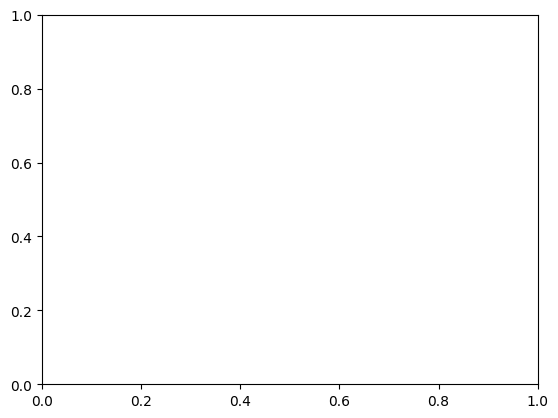

In [ ]:
import matplotlib.pyplot as plt

plt.plot(DDPG_agent.env.portfolio_history[1:])
print(DDPG_agent.env.portfolio_history)
plt.title("Portfolio Change Over Time")
plt.xlabel("Steps")
plt.ylabel("Portfolio value")
plt.show()